# Рейтинг маршрутов
__Идея:__ помочь планировщикам выбрать самые выгодные маршруты за период.

__Цель:__ Оценка маршрутов (регионов, почтовых кодов) при помощи разных методик и составление рейтинга маршрутов.

__Задачи:__

1. Разработать методики оценки маршрутов (регионов, почтовых кодов).
2. Рассчитать рейтинги маршрутов (регионов, почтовых кодов) по различным методикам.
3. Проанализировать и сопоставить результаты полученных рейтингов.

__Методики:__

- Principal Component Analysis (PCA)
- Data Envelopment Analysis (DEA)

__Исходные данные:__
1. Маршрут (Route)
2. Регионы (Regions)
3. Почтовые коды (PostCodes)
4. Тип прицепа (TrailerType)
5. Тип груза (CargoWeight)
6. Вес груза (CargoType)
7. Пробег (Mileage)
8. Дни (Days)
9. Доход (Income)

## Импорт библиотек

In [1]:
# Libraries loading
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

#from sklearn.cross_validation import train_test_split
from sklearn import datasets
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler # Normalization MinMax
#from sklearn.preprocessing import StandardScaler # Normalization Std

from scipy.stats import stats, kstest, norm
import math

from sklearn.decomposition import PCA

#from pyDEA.core.utils import dea_utils
#from pyDEA import main_gui
#import pyDEA as dea
#import pyDEA
#import keras

## Форматирование, очистка и преобразование данных

### Загрузка данных

In [2]:
df = pd.read_csv('data.csv', encoding='cp1251')
df = df[['id', 'Route', 'Regions', 'PostCodes', 'TrailerType', 'CargoType', 'CargoWeight', 'DriversNumber', 'Days', 'Mileage',
        'Income']] 
df.head()

D:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
0,1131,LV-BG,Baltics-Balkans / Turkey,LV42 - BG53,РЕФ,Стекловолокно,0.0,1,40.250000,2872.785,2150.0
1,141212,NO-ES,Norway (South)-Spain,NO60 - ES28,РЕФ,рыба (свежая),0.0,1,32.358333,3525.411,3657.0
2,138082,DE-DE,BENELUX-BENELUX,DE47 - DE30,ТЕНТ,Почта DPD,0.0,2,30.020833,275.803,402.2
3,56314,LV-BG,Baltics-Balkans / Turkey,LV - BG,РЕФ,NaN,0.0,1,23.916667,2775.793,2150.0
4,47157,LV-IT,Baltics-Italy,LVLV - IT17,РЕФ,торф,0.0,1,23.134028,2500.001,1400.0


### Форматирование данных

In [3]:
df['CargoWeight'] = pd.to_numeric(df['CargoWeight']).astype(np.float64)
df['Days'] = pd.to_numeric(df['Days']).astype(np.float64)
df['Mileage'] = pd.to_numeric(df['Mileage']).astype(np.float64)
df['Income'] = pd.to_numeric(df['Income']).astype(np.float64)

### Пропущенные значения 

In [4]:
# See the column data types and non-missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180072 entries, 0 to 180071
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             180072 non-null  int64  
 1   Route          180072 non-null  object 
 2   Regions        180072 non-null  object 
 3   PostCodes      180072 non-null  object 
 4   TrailerType    180044 non-null  object 
 5   CargoType      173943 non-null  object 
 6   CargoWeight    180042 non-null  float64
 7   DriversNumber  180072 non-null  object 
 8   Days           180072 non-null  float64
 9   Mileage        180072 non-null  float64
 10  Income         180072 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 15.1+ MB


## Выбросы
Поиск и удаление выбросов по каждой переменной по квартилям и дополнительная проверка переменных по индивидуальным условиям, удаление и/или замена пустых значений на среднее.

In [5]:
# Кол-во строк в исходном df
len(df)

180072

### Income

В колонке "Доход" есть записи с нулевым доходом или ниже, такие записи необходимо удалить. Затем убрать выбросы по квартилям.

#### Удаление записей с доходом 0 и ниже
Ошибка в данных, необходимо удалить такие строки.

In [6]:
df = df[df.Income>0]
# Проверка кол-ва строк после удаления строк с нулевым доходом и ниже 0
len(df)

180037

In [7]:
# Переназначение индексов после удаления строк
df.index=pd.RangeIndex(start=0,stop=len(df),step=1)
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
0,1131,LV-BG,Baltics-Balkans / Turkey,LV42 - BG53,РЕФ,Стекловолокно,0.0,1,40.250000,2872.785,2150.0
1,141212,NO-ES,Norway (South)-Spain,NO60 - ES28,РЕФ,рыба (свежая),0.0,1,32.358333,3525.411,3657.0
2,138082,DE-DE,BENELUX-BENELUX,DE47 - DE30,ТЕНТ,Почта DPD,0.0,2,30.020833,275.803,402.2
3,56314,LV-BG,Baltics-Balkans / Turkey,LV - BG,РЕФ,NaN,0.0,1,23.916667,2775.793,2150.0
4,47157,LV-IT,Baltics-Italy,LVLV - IT17,РЕФ,торф,0.0,1,23.134028,2500.001,1400.0


In [8]:
# Summary
df.Income.describe()

count    180037.000000
mean        865.505762
std         785.015987
min           0.010000
25%         375.900000
50%         555.840000
75%        1170.000000
max        7600.000000
Name: Income, dtype: float64

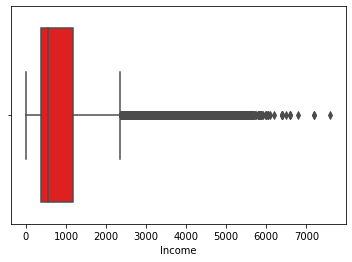

In [9]:
# При помощи этого графика смотрим выбросы (точки на графике), от них нужно избавляться
sns.boxplot(df.Income, color='red')

#### Удаление выбросов

In [10]:
# Кол-во строк перед удалением выбросов
len(df)

180037

In [11]:
# Поиск и удаление выбросов
first_quartile = df["Income"].describe()['25%']
third_quartile = df["Income"].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
df = df[(df["Income"] > (first_quartile - 3 * iqr)) &
            (df["Income"] < (third_quartile + 3 * iqr))]

len(df)

176548

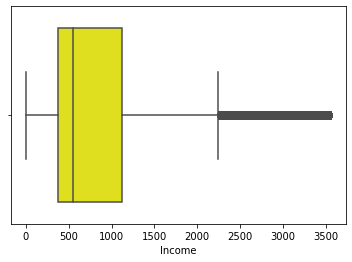

In [12]:
# Проверка данных после удаления выбросов на пред. шаге
sns.boxplot(df.Income, color='yellow')

Text(0.5, 1.0, 'Income Distribution')

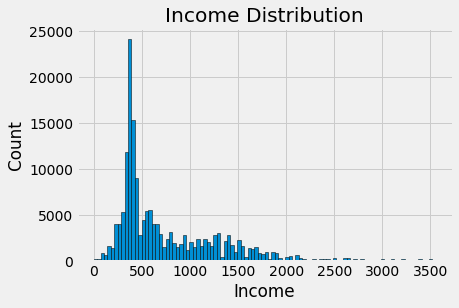

In [13]:
# Распределение переменной "Доход"
plt.style.use('fivethirtyeight')
plt.hist(df['Income'].dropna(), bins = 100, edgecolor = 'black')
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Income Distribution')

In [14]:
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
0,1131,LV-BG,Baltics-Balkans / Turkey,LV42 - BG53,РЕФ,Стекловолокно,0.0,1,40.250000,2872.785,2150.0
2,138082,DE-DE,BENELUX-BENELUX,DE47 - DE30,ТЕНТ,Почта DPD,0.0,2,30.020833,275.803,402.2
3,56314,LV-BG,Baltics-Balkans / Turkey,LV - BG,РЕФ,NaN,0.0,1,23.916667,2775.793,2150.0
4,47157,LV-IT,Baltics-Italy,LVLV - IT17,РЕФ,торф,0.0,1,23.134028,2500.001,1400.0
5,91502,LV-IT,Baltics-Italy,LVLV - IT12,РЕФ,торф,0.0,1,22.449306,2543.466,1400.0


In [15]:
# Переназначение индексов после удаления строк
df.index=pd.RangeIndex(start=0,stop=len(df),step=1)
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
0,1131,LV-BG,Baltics-Balkans / Turkey,LV42 - BG53,РЕФ,Стекловолокно,0.0,1,40.250000,2872.785,2150.0
1,138082,DE-DE,BENELUX-BENELUX,DE47 - DE30,ТЕНТ,Почта DPD,0.0,2,30.020833,275.803,402.2
2,56314,LV-BG,Baltics-Balkans / Turkey,LV - BG,РЕФ,NaN,0.0,1,23.916667,2775.793,2150.0
3,47157,LV-IT,Baltics-Italy,LVLV - IT17,РЕФ,торф,0.0,1,23.134028,2500.001,1400.0
4,91502,LV-IT,Baltics-Italy,LVLV - IT12,РЕФ,торф,0.0,1,22.449306,2543.466,1400.0


### Mileage

В колонке "Пробег" записи с нулевыми, пропущенными значениями<!--,а также строки, где значение дней больше значений пробегов,-->  заменяем на среднее значение.
Затем убрать выбросы по квартилям.

#### Поиск записей с нулевым и незаполненным пробегом

In [16]:
# Кол-во строк 
len(df)

176548

In [17]:
# Кол-во строк, в которых пробег равен 0 или не заполнен
#df.shape[0]-
df.id[(round(df.Mileage)==0) | (df.Mileage.isna())].count()

3110

In [18]:
df[(round(df.Mileage)==0) | (df.Mileage.isna())]

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
9,149906,FR-LT,no data-no data,FR - LT,РЕФ,NaN,NaN,-,19.000000,0.000,3200.00
11,95608,DE-DE,CentralEurope-CentralEurope,DE63 - DE63,РЕФ,Почта DPD,0.0,1,18.000000,0.000,215.00
16,121913,FR-LV,no data-no data,FR - LV,РЕФ,NaN,NaN,-,15.000000,0.000,1200.00
27,87405,ES-LV,no data-no data,ES - LV,РЕФ,NaN,NaN,-,14.000000,0.000,3300.00
163,36096,IT-LV,no data-no data,IT - LV,РЕФ,NaN,NaN,-,10.000000,0.000,1300.00
...,...,...,...,...,...,...,...,...,...,...,...
176486,58585,IT-IT,Italy-Italy,IT29 - IT29,РЕФ,Почта DPD,0.0,2,0.020139,0.000,400.00
176495,78379,DE-DE,BENELUX-BENELUX,DE41 - DE44,ТЕНТ,Почта DPD,0.0,2,0.020139,0.192,366.71
176504,98655,DE-DE,BENELUX-BENELUX,DE41 - DE41,РЕФ,Почта DPD,0.0,2,0.020139,0.000,400.00
176506,100883,FR-FR,BENELUX-BENELUX,FR59 - FR59,ТЕНТ,Почта DPD,0.0,2,0.020139,0.004,373.37


In [19]:
# Summary
df.Mileage.describe()

count    176548.000000
mean        657.088905
std         621.082470
min           0.000000
25%         241.001000
50%         496.062000
75%         859.658000
max       11760.441000
Name: Mileage, dtype: float64

In [20]:
# Среднее значение пробега 
#mean_Mileage=df.Mileage[df.Days.value_counts()].mean()
mean_Mileage = (df.Mileage[df.Mileage>0]/np.ceil(df.Days)).mean()
mean_Mileage

371.71453936634146

#### Замена записей с нулевым пробегом на средний 

In [21]:
# Replace 0 values with np.NaN
df['Mileage'] = round(df['Mileage']).replace(0, np.NaN)
df.Mileage[round(df.Mileage)==0].count()

0

In [22]:
df[(round(df.Mileage)==0) | (df.Mileage.isna())]

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
9,149906,FR-LT,no data-no data,FR - LT,РЕФ,NaN,NaN,-,19.000000,NaN,3200.00
11,95608,DE-DE,CentralEurope-CentralEurope,DE63 - DE63,РЕФ,Почта DPD,0.0,1,18.000000,NaN,215.00
16,121913,FR-LV,no data-no data,FR - LV,РЕФ,NaN,NaN,-,15.000000,NaN,1200.00
27,87405,ES-LV,no data-no data,ES - LV,РЕФ,NaN,NaN,-,14.000000,NaN,3300.00
163,36096,IT-LV,no data-no data,IT - LV,РЕФ,NaN,NaN,-,10.000000,NaN,1300.00
...,...,...,...,...,...,...,...,...,...,...,...
176486,58585,IT-IT,Italy-Italy,IT29 - IT29,РЕФ,Почта DPD,0.0,2,0.020139,NaN,400.00
176495,78379,DE-DE,BENELUX-BENELUX,DE41 - DE44,ТЕНТ,Почта DPD,0.0,2,0.020139,NaN,366.71
176504,98655,DE-DE,BENELUX-BENELUX,DE41 - DE41,РЕФ,Почта DPD,0.0,2,0.020139,NaN,400.00
176506,100883,FR-FR,BENELUX-BENELUX,FR59 - FR59,ТЕНТ,Почта DPD,0.0,2,0.020139,NaN,373.37


In [23]:
df.Mileage = df.Mileage.fillna(mean_Mileage)
df.Mileage.head()

0    2873.0
1     276.0
2    2776.0
3    2500.0
4    2543.0
Name: Mileage, dtype: float64

<!--# Replace rows where Days > Mileage with np.NaN
df['Mileage'] = df.Mileage.replace(df.Mileage[(np.ceil(df.Days)>np.ceil(df.Mileage))], mean_Mileage) 
df.Mileage[(np.ceil(df.Days)>np.ceil(df.Mileage))].count()-->

In [24]:
df.Mileage.describe()

count    176548.000000
mean        663.635851
std         616.059494
min           1.000000
25%         260.000000
50%         496.000000
75%         860.000000
max       11760.000000
Name: Mileage, dtype: float64

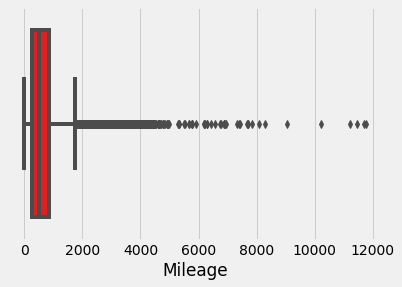

In [25]:
# При помощи этого графика смотрим выбросы (точки на графике), от них нужно избавляться
sns.boxplot(df.Mileage, color='red')

#### Удаление выбросов

In [26]:
# Кол-во строк перед удалением выбросов
len(df)

176548

In [27]:
# Поиск и удаление выбросов
first_quartile = df["Mileage"].describe()['25%']
third_quartile = df["Mileage"].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
df = df[(df["Mileage"] > (first_quartile - 3 * iqr)) &
            (df["Mileage"] < (third_quartile + 3 * iqr))]

len(df)

173880

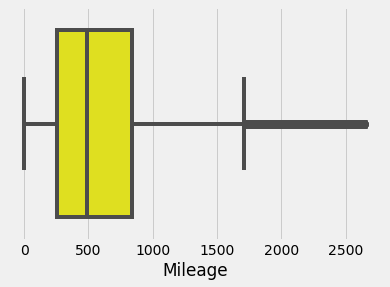

In [28]:
# Проверка данных после удаления выбросов на пред. шаге
sns.boxplot(df.Mileage, color='yellow')

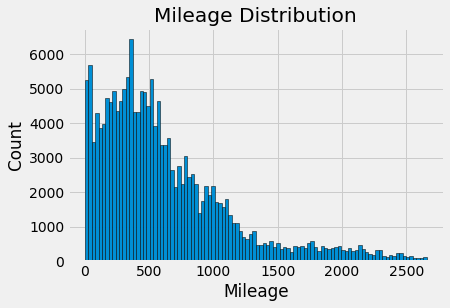

In [29]:
# Распределение переменной "Пробег"
plt.style.use('fivethirtyeight')
plt.hist(df['Mileage'].dropna(), bins = 100, edgecolor = 'black');
plt.xlabel('Mileage'); 
plt.ylabel('Count'); plt.title('Mileage Distribution');

Text(0, 0.5, 'Income')

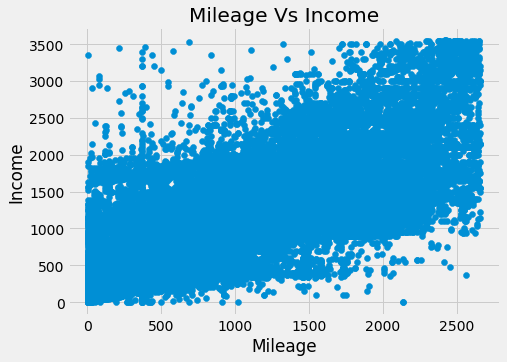

In [30]:
# На графике смотрим связь между доходом и пробегом
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(x = df['Mileage'], y = df['Income'], marker = 'o')
axes.set_title('Mileage Vs Income')
axes.set_xlabel('Mileage')
axes.set_ylabel('Income')

In [31]:
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
1,138082,DE-DE,BENELUX-BENELUX,DE47 - DE30,ТЕНТ,Почта DPD,0.0,2,30.020833,276.0,402.2
3,47157,LV-IT,Baltics-Italy,LVLV - IT17,РЕФ,торф,0.0,1,23.134028,2500.0,1400.0
4,91502,LV-IT,Baltics-Italy,LVLV - IT12,РЕФ,торф,0.0,1,22.449306,2543.0,1400.0
5,16897,LV-IT,Baltics-Italy,LVLV - IT26,РЕФ,торф,0.0,1,20.319444,2286.0,1450.0
6,156017,LV-IT,Baltics-Italy,LVLV - IT26,РЕФ,торф,0.0,1,19.925000,2277.0,1400.0


In [32]:
# Переназначение индексов после удаления строк
df.index=pd.RangeIndex(start=0,stop=len(df),step=1)
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
0,138082,DE-DE,BENELUX-BENELUX,DE47 - DE30,ТЕНТ,Почта DPD,0.0,2,30.020833,276.0,402.2
1,47157,LV-IT,Baltics-Italy,LVLV - IT17,РЕФ,торф,0.0,1,23.134028,2500.0,1400.0
2,91502,LV-IT,Baltics-Italy,LVLV - IT12,РЕФ,торф,0.0,1,22.449306,2543.0,1400.0
3,16897,LV-IT,Baltics-Italy,LVLV - IT26,РЕФ,торф,0.0,1,20.319444,2286.0,1450.0
4,156017,LV-IT,Baltics-Italy,LVLV - IT26,РЕФ,торф,0.0,1,19.925000,2277.0,1400.0


### Days

В колонке "Дни" проверяем записи на наличие нулевых и пропущенных значениями. 
Затем убираем выбросы по квартилям.

#### Поиск записей с нулевыми и незаполненными днями

In [33]:
len(df)

173880

In [34]:
# Кол-во строк с нулевым значением и незаполненных
#df.shape[0]-
df.id[(df.Days==0) | df.Days.isna()].count()

0

In [35]:
# Summary
df.Days.describe()

count    173880.000000
mean          1.183277
std           1.191321
min           0.020139
25%           0.340278
50%           0.833333
75%           1.701389
max          30.020833
Name: Days, dtype: float64

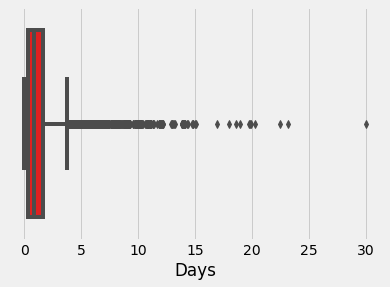

In [36]:
# При помощи этого графика смотрим выбросы (точки на графике), от них нужно избавляться
sns.boxplot(df.Days, color='red')

#### Удаление выбросов

In [37]:
# Кол-во строк перед удалением выбросов
len(df)

173880

In [38]:
# Поиск и удаление выбросов
first_quartile = df["Days"].describe()['25%']
third_quartile = df["Days"].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
df = df[(df["Days"] > (first_quartile - 3 * iqr)) &
            (df["Days"] < (third_quartile + 3 * iqr))]

len(df)

172775

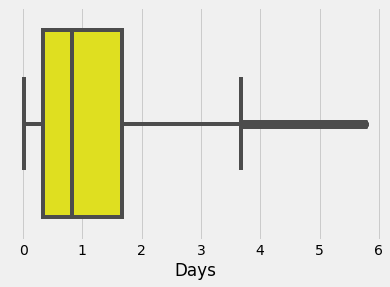

In [39]:
# Проверка данных после удаления выбросов на пред. шаге
sns.boxplot(df.Days, color='yellow')

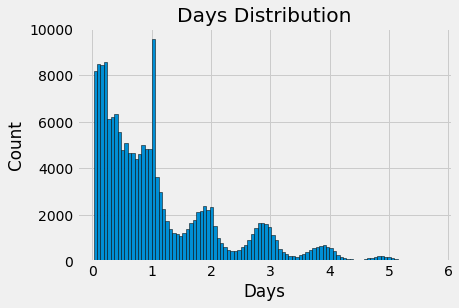

In [40]:
# Распределение переменной "Дни"
plt.style.use('fivethirtyeight')
plt.hist(df['Days'].dropna(), bins = 100, edgecolor = 'black');
plt.xlabel('Days'); 
plt.ylabel('Count'); plt.title('Days Distribution');

Text(0, 0.5, 'Income')

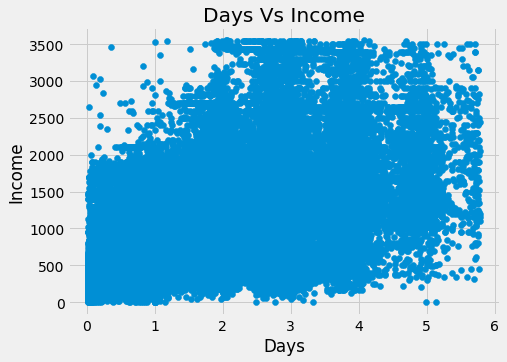

In [41]:
# На графике смотрим связь между доходом и днями
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(x = df['Days'], y = df['Income'], marker = 'o')
axes.set_title('Days Vs Income')
axes.set_xlabel('Days')
axes.set_ylabel('Income')

In [42]:
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
1105,145269,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,РЕФ,молочные продукты,0.0,1,5.783333,2121.0,2450.00
1106,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,ТЕНТ,Паллеты,0.0,1,5.782662,1925.0,2056.54
1107,146618,LV-BE,Baltics-BENELUX,LVLV - BE08,РЕФ,Древесина,0.0,1,5.781944,2100.0,1100.00
1108,164866,AT-DE,CentralEurope-BENELUX,AT50 - DE29,РЕФ,шоколад (темп),0.0,1,5.780556,1243.0,1200.00
1109,95810,LV-IT,Baltics-Italy,LVLV - IT48,РЕФ,мука,0.0,1,5.779861,2215.0,1150.00


In [43]:
# Переназначение индексов после удаления строк
df.index=pd.RangeIndex(start=0,stop=len(df),step=1)
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
0,145269,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,РЕФ,молочные продукты,0.0,1,5.783333,2121.0,2450.00
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,ТЕНТ,Паллеты,0.0,1,5.782662,1925.0,2056.54
2,146618,LV-BE,Baltics-BENELUX,LVLV - BE08,РЕФ,Древесина,0.0,1,5.781944,2100.0,1100.00
3,164866,AT-DE,CentralEurope-BENELUX,AT50 - DE29,РЕФ,шоколад (темп),0.0,1,5.780556,1243.0,1200.00
4,95810,LV-IT,Baltics-Italy,LVLV - IT48,РЕФ,мука,0.0,1,5.779861,2215.0,1150.00


## Route

В колонке "Маршруты" могут содержаться неполные записи (только с одной страной - отправления или прибытия), такие записи необходимо удалить.

In [44]:
len(df)

172775

#### Поиск записей с не полностью заполненным маршрутом

In [45]:
# Кол-во пустых и незаполненных маршрутов 
#df.shape[0]-
df.Route[(df.Route=='-') | (df.Route.isna())].count()

0

In [46]:
# Find rows with not fully filled routes (only one of countries)
remove_index_routes = []
df['Route'][1].split('-')
for i in range(len(df.Route)):
    if(df['Route'][i].split('-')[0]=='' or df['Route'][i].split('-')[1]==''):
        remove_index_routes.append(i)
        df=df.drop(i)
print(remove_index_routes) 

[]


In [47]:
len(df)

172775

In [48]:
# Summary
df.Route.describe()

count     172775
unique       509
top        DE-DE
freq       30443
Name: Route, dtype: object

## CargoWeight

В колонке "Вес груза" необходимо проверить количество нулевых и незаполненных значений. 

#### Поиск записей с нулевыми и незаполненными весами грузов

In [49]:
len(df)

172775

In [50]:
# Кол-во записей с нулевым значением и незаполненных
#df.shape[0]-
df.id[(df.CargoWeight==0) | (df.CargoWeight.isna())].count()

166901

Т.к. очень мало заполненных значений, удаляем колонку CargoWeight.

In [51]:
# Remove column 'CargoWeight' because only 6000 rows not are null or 0
df = df.iloc[:,df.columns!='CargoWeight']
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income
0,145269,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,РЕФ,молочные продукты,1,5.783333,2121.0,2450.00
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,ТЕНТ,Паллеты,1,5.782662,1925.0,2056.54
2,146618,LV-BE,Baltics-BENELUX,LVLV - BE08,РЕФ,Древесина,1,5.781944,2100.0,1100.00
3,164866,AT-DE,CentralEurope-BENELUX,AT50 - DE29,РЕФ,шоколад (темп),1,5.780556,1243.0,1200.00
4,95810,LV-IT,Baltics-Italy,LVLV - IT48,РЕФ,мука,1,5.779861,2215.0,1150.00


## CargoType

В колонке "Тип груза" необходимо проверить количество нулевых и незаполненных значений. Заменить эти значения на самое часто встречающееся.

#### Поиск записей с нулевым и незаполненным типом грузов

In [52]:
len(df)

172775

In [53]:
# Кол-во записей с незаполненным грузом
#df.shape[0]-
df.id[(df.CargoType.isna())].count()

5970

#### Замена записей с незаполненным типом груза на самый часто встречающийся

In [54]:
# Summary
df.CargoType.describe()

count        166805
unique          185
top       Почта DPD
freq          69689
Name: CargoType, dtype: object

In [55]:
# Самый часто встречающийся тип груза 
max_count_CargoType = df.CargoType.describe().top
max_count_CargoType

'Почта DPD'

In [56]:
# Замена пустых значений на самое часто встречающееся
df.CargoType = df.CargoType.fillna(max_count_CargoType)
df.CargoType

0         молочные продукты
1                   Паллеты
2                 Древесина
3            шоколад (темп)
4                      мука
                ...        
172770            Почта DPD
172771            Почта DPD
172772            Почта DPD
172773            Почта DPD
172774            Почта DPD
Name: CargoType, Length: 172775, dtype: object

#### Преобразование колонки 'CargoType' в категориальную переменную

In [57]:
# Check how many categories in 'CargoType'
pd.get_dummies(df.CargoType).shape

(172775, 185)

In [58]:
# Создание отдельных колонок по уникальным значениям типа груза
#df = df.join(df_CargoType)
#df.head()

In [59]:
#df = df.drop(columns=['CargoType'])
#df.head()

## TrailerType

В колонке "Тип прицепа" проверяем наличие незаполненных записей. Заменяем на самое часто встречающееся в случае пропусков.
Далее преобразовываем переменную в фиктивные, разбив на количество уникальных значений данной переменной.

Тип груза тент был полностью удален на этапе выбросов (выше).

#### Поиск записей с нулевым и незаполненным типом прицепов

In [60]:
len(df)

172775

In [61]:
# Кол-во незаполненных строк
#df.shape[0]-
df.id[(df.TrailerType.isna())].count()

23

#### Замена записей с незаполненным типом прицепа на самый часто встречающийся

In [62]:
# Summary
df.TrailerType.describe()

count     172752
unique         2
top          РЕФ
freq      104433
Name: TrailerType, dtype: object

In [63]:
# Самый часто встречающийся тип груза 
max_count_TrailerType = df.TrailerType.describe().top
max_count_TrailerType

'РЕФ'

In [64]:
# Замена незаполненных значений на самый часто встречающийся
df.TrailerType = df.TrailerType.fillna(max_count_TrailerType)
df.TrailerType

0          РЕФ
1         ТЕНТ
2          РЕФ
3          РЕФ
4          РЕФ
          ... 
172770    ТЕНТ
172771    ТЕНТ
172772    ТЕНТ
172773    ТЕНТ
172774    ТЕНТ
Name: TrailerType, Length: 172775, dtype: object

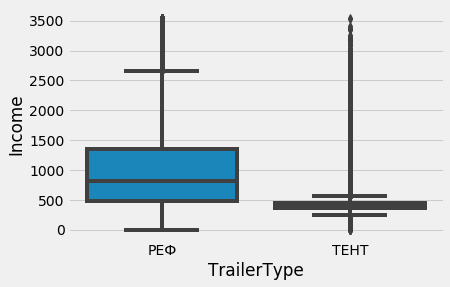

In [65]:
# Income by CargoType
sns.boxplot(x = 'TrailerType', y='Income', data=df)

#### График плотности категориальной переменной (TrailerType)

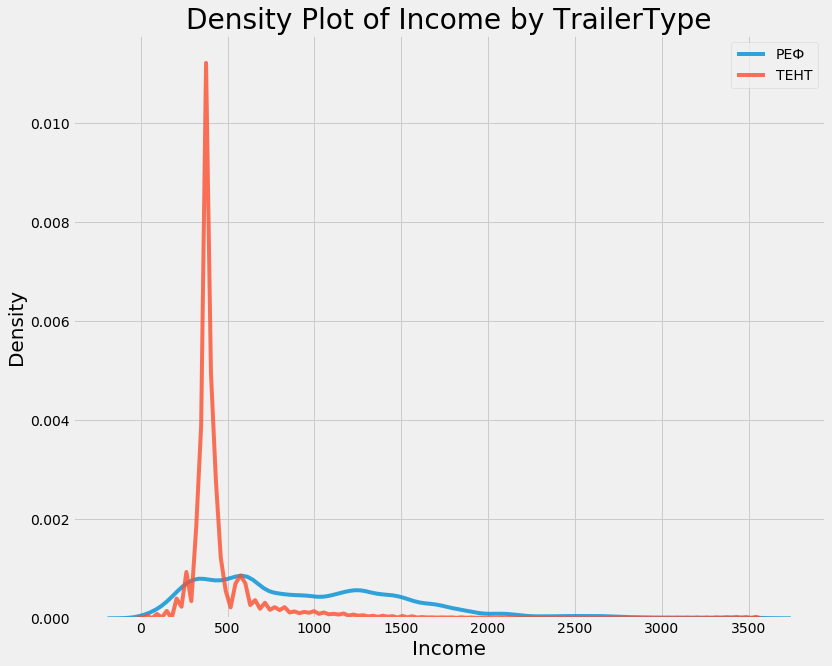

In [66]:
# Create a list of buildings with more than 100 measurements
types = df.dropna(subset=['Income'])
types = types['TrailerType'].value_counts()
types = list(types[types.values > 100].index)

# Plot of distribution of scores for building categories
figsize(12, 10)

# Plot each building
for b_type in types:
    # Select the building type
    subset = df[df['TrailerType'] == b_type]
    
    # Density plot of Energy Star Scores
    sns.kdeplot(subset['Income'].dropna(),
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Income', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Income by TrailerType', size = 28);

#### Преобразование колонки 'TrailerType' в категориальную переменную

In [67]:
# Check how many categories in 'TrailerType'
pd.get_dummies(df.TrailerType).shape

(172775, 2)

In [68]:
df_trailerType = pd.get_dummies(df.TrailerType)
df_trailerType.head()

,РЕФ,ТЕНТ
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0


In [69]:
df = df.join(df_trailerType)
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,РЕФ,ТЕНТ
0,145269,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,РЕФ,молочные продукты,1,5.783333,2121.0,2450.00,1,0
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,ТЕНТ,Паллеты,1,5.782662,1925.0,2056.54,0,1
2,146618,LV-BE,Baltics-BENELUX,LVLV - BE08,РЕФ,Древесина,1,5.781944,2100.0,1100.00,1,0
3,164866,AT-DE,CentralEurope-BENELUX,AT50 - DE29,РЕФ,шоколад (темп),1,5.780556,1243.0,1200.00,1,0
4,95810,LV-IT,Baltics-Italy,LVLV - IT48,РЕФ,мука,1,5.779861,2215.0,1150.00,1,0


#### Преобразование текстовых значений в числовые для колонки 'TrailerType' 

In [70]:
TrailerType_unique = {'РЕФ': 1, 'ТЕНТ': 2, 'КОНТЕЙНЕР': 3}

df['TrailerType'] = df['TrailerType'].apply(TrailerType_unique.get)
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,РЕФ,ТЕНТ
0,145269,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,5.783333,2121.0,2450.00,1,0
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,5.782662,1925.0,2056.54,0,1
2,146618,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,5.781944,2100.0,1100.00,1,0
3,164866,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,5.780556,1243.0,1200.00,1,0
4,95810,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,5.779861,2215.0,1150.00,1,0


In [71]:
#df = df.drop(columns=['TrailerType'])
#df.head()

In [72]:
df = df.rename(columns={"КОНТЕЙНЕР": "Container", "РЕФ": "Ref", "ТЕНТ": "Canvas"})
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,Ref,Canvas
0,145269,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,5.783333,2121.0,2450.00,1,0
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,5.782662,1925.0,2056.54,0,1
2,146618,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,5.781944,2100.0,1100.00,1,0
3,164866,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,5.780556,1243.0,1200.00,1,0
4,95810,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,5.779861,2215.0,1150.00,1,0


## Income_per_Km

Создание дополнительной переменной "Доход на километр". 

In [73]:
len(df)

172775

In [74]:
df['Income_per_Km'] = df.Income/df.Mileage
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,Ref,Canvas,Income_per_Km
0,145269,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,5.783333,2121.0,2450.00,1,0,1.155116
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,5.782662,1925.0,2056.54,0,1,1.068332
2,146618,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,5.781944,2100.0,1100.00,1,0,0.523810
3,164866,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,5.780556,1243.0,1200.00,1,0,0.965406
4,95810,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,5.779861,2215.0,1150.00,1,0,0.519187


In [75]:
# Summary
df.Income_per_Km.describe()

count    172775.000000
mean          4.209787
std          26.966754
min           0.000005
25%           0.985732
50%           1.274797
75%           1.821925
max        1904.670000
Name: Income_per_Km, dtype: float64

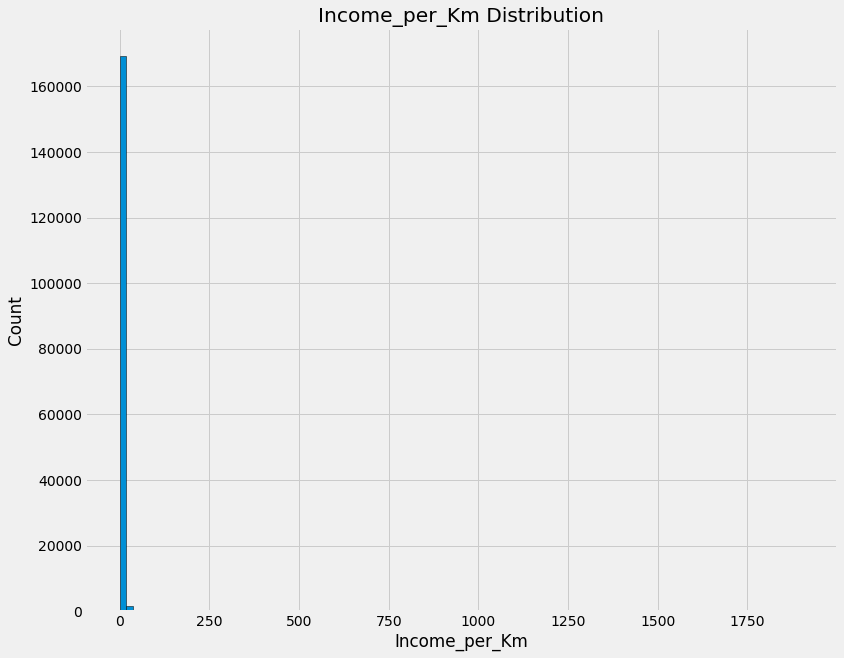

In [76]:
#figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.hist(df['Income_per_Km'].dropna(), bins = 100, edgecolor = 'black');
plt.xlabel('Income_per_Km'); 
plt.ylabel('Count'); plt.title('Income_per_Km Distribution');

## Income_per_Day

Создание дополнительной переменной "Доход на день".

In [77]:
len(df)

172775

In [78]:
df['Income_per_Day'] = df.Income/df.Days
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,Ref,Canvas,Income_per_Km,Income_per_Day
0,145269,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,5.783333,2121.0,2450.00,1,0,1.155116,423.631124
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,5.782662,1925.0,2056.54,0,1,1.068332,355.638975
2,146618,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,5.781944,2100.0,1100.00,1,0,0.523810,190.247418
3,164866,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,5.780556,1243.0,1200.00,1,0,0.965406,207.592504
4,95810,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,5.779861,2215.0,1150.00,1,0,0.519187,198.966719


In [79]:
# Summary
df.Income_per_Day.describe()

count    172775.000000
mean       1500.952435
std        2542.790592
min           0.001946
25%         490.212766
50%         802.973978
75%        1494.763634
max       70452.000000
Name: Income_per_Day, dtype: float64

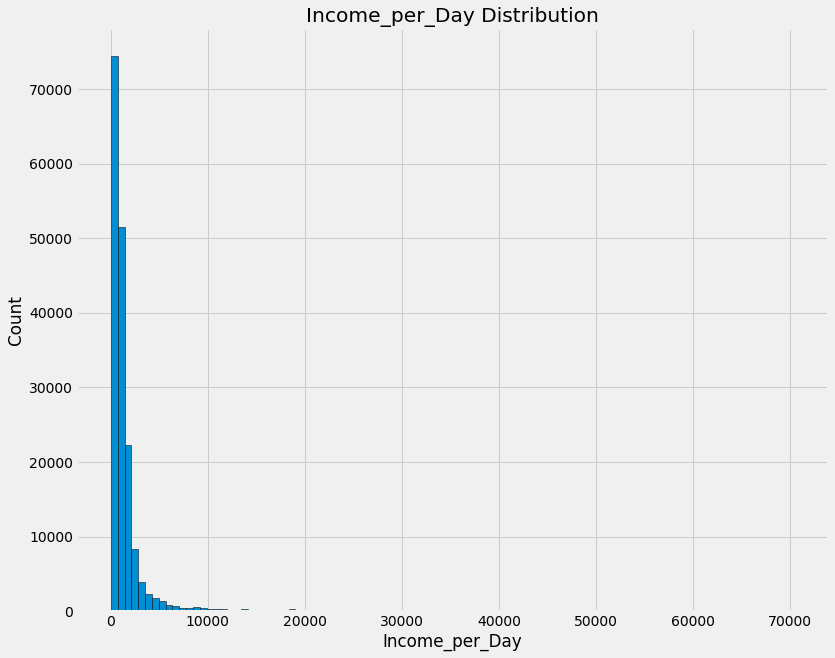

In [80]:
#figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.hist(df['Income_per_Day'].dropna(), bins = 100, edgecolor = 'black');
plt.xlabel('Income_per_Day'); 
plt.ylabel('Count'); plt.title('Income_per_Day Distribution');

## Проверка статистики после преобразования данных

Проверка остались ли незаполненные значения переменных

In [81]:
# Check null values in columns
df.isnull().sum()

id                0
Route             0
Regions           0
PostCodes         0
TrailerType       0
CargoType         0
DriversNumber     0
Days              0
Mileage           0
Income            0
Ref               0
Canvas            0
Income_per_Km     0
Income_per_Day    0
dtype: int64

In [82]:
# Summary after data transformation
df[['Days', 'Income', 'Mileage', 'Income_per_Km', 'Income_per_Day']].describe()

,Days,Income,Mileage,Income_per_Km,Income_per_Day
count,172775.000000,172775.000000,172775.000000,172775.000000,172775.000000
mean,1.144069,760.658371,614.214934,4.209787,1500.952435
std,1.075191,554.960093,505.728970,26.966754,2542.790592
min,0.020139,0.010000,1.000000,0.000005,0.001946
25%,0.336806,374.650000,254.000000,0.985732,490.212766
50%,0.829861,531.640000,485.000000,1.274797,802.973978
75%,1.672222,1088.590000,829.000000,1.821925,1494.763634
max,5.783333,3552.020000,2659.000000,1904.670000,70452.000000


In [83]:
df_sc = df.copy()

## Проверка данных на нормальное распределение
Проверка данных на линейность

#### Income

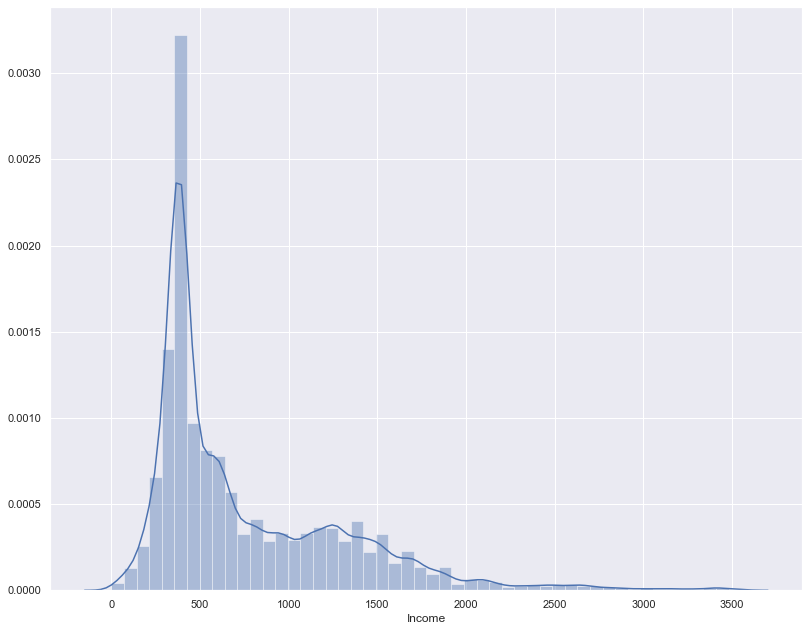

In [84]:
sns.set()
sns.distplot(df_sc['Income'])

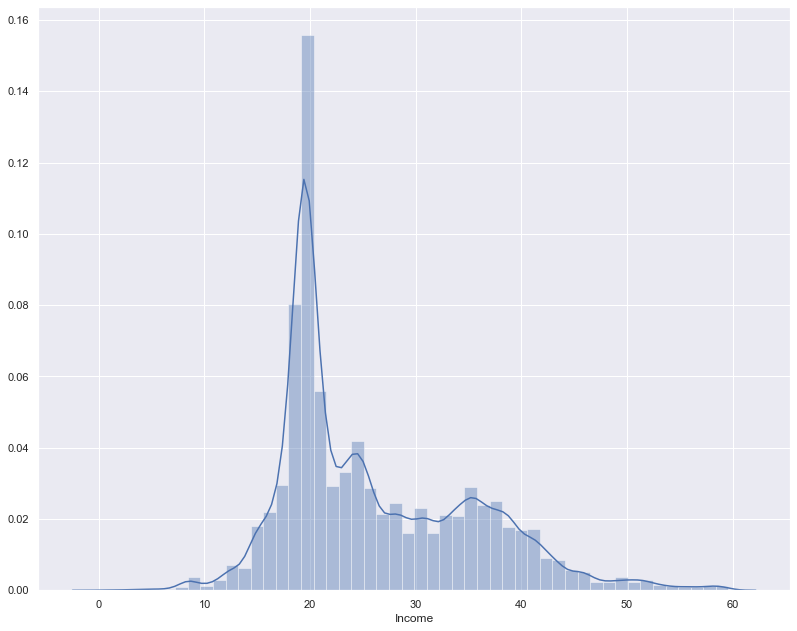

In [85]:
# Sqrt 'Income' 
sns.set()
sns.distplot(np.sqrt(df_sc.Income))

#### Mileage

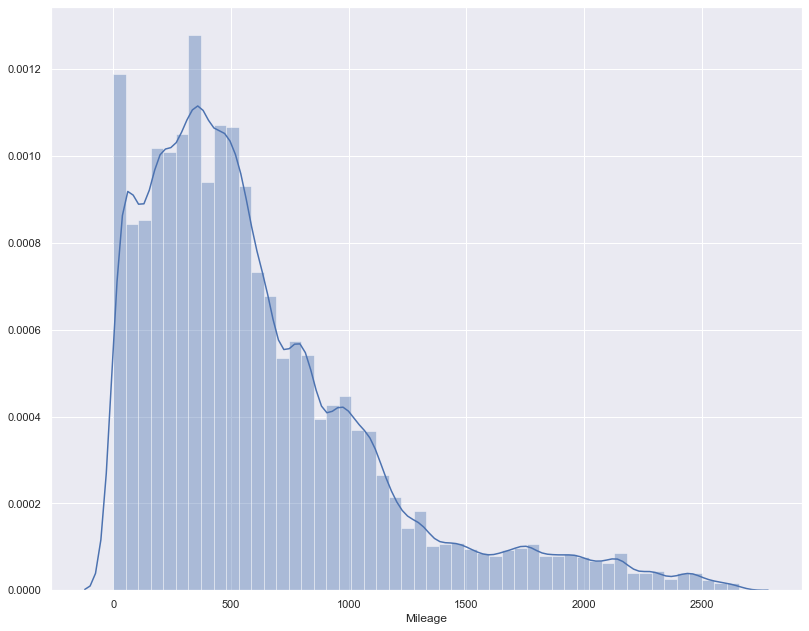

In [86]:
sns.set()
sns.distplot(df_sc['Mileage'])

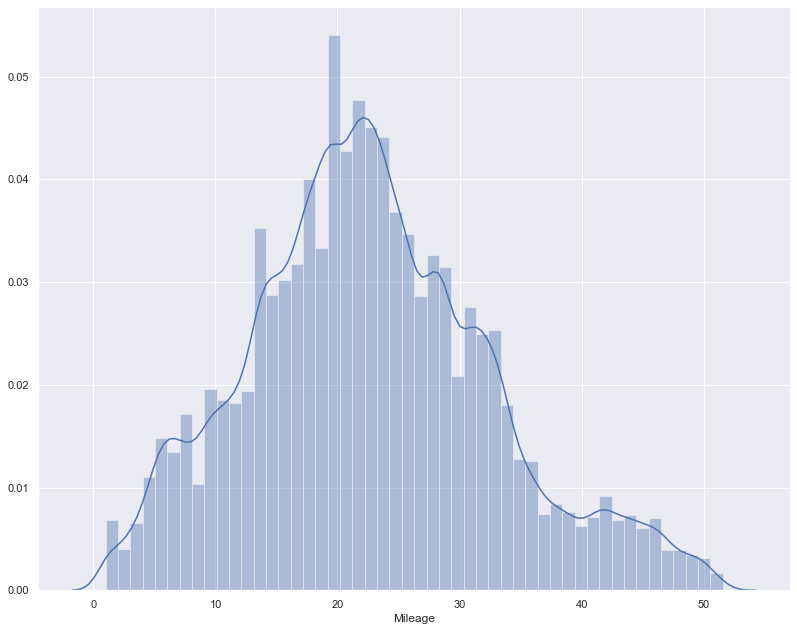

In [87]:
# Sqrt 'Mileage' 
sns.set()
sns.distplot(np.sqrt(df_sc.Mileage))

#### Days

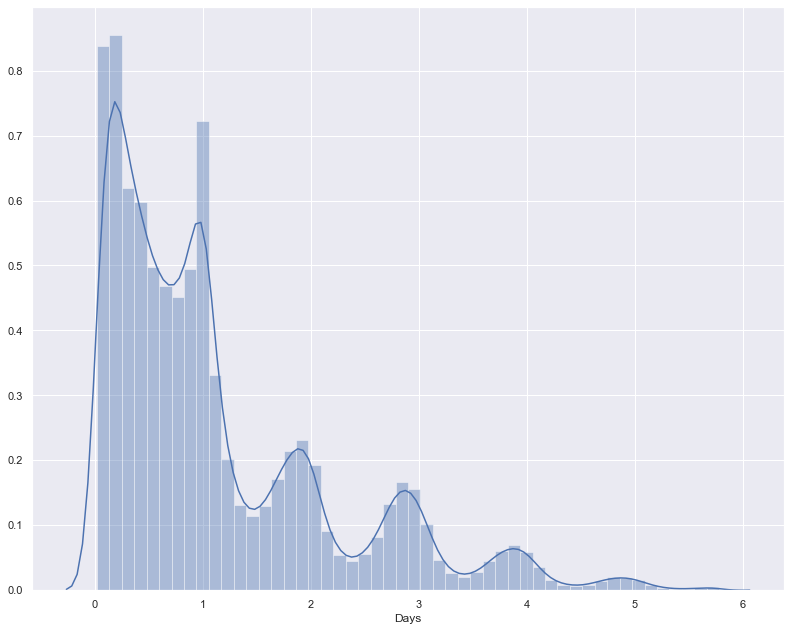

In [88]:
sns.set()
sns.distplot(df_sc['Days'])

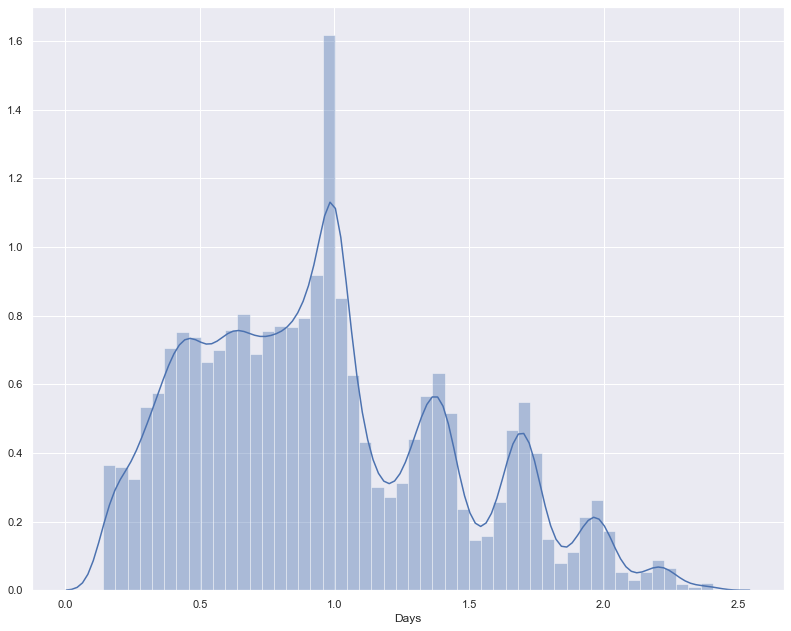

In [89]:
# Sqrt 'Days' 
sns.set()
sns.distplot(np.sqrt(df_sc.Days))

#### Income_per_Km

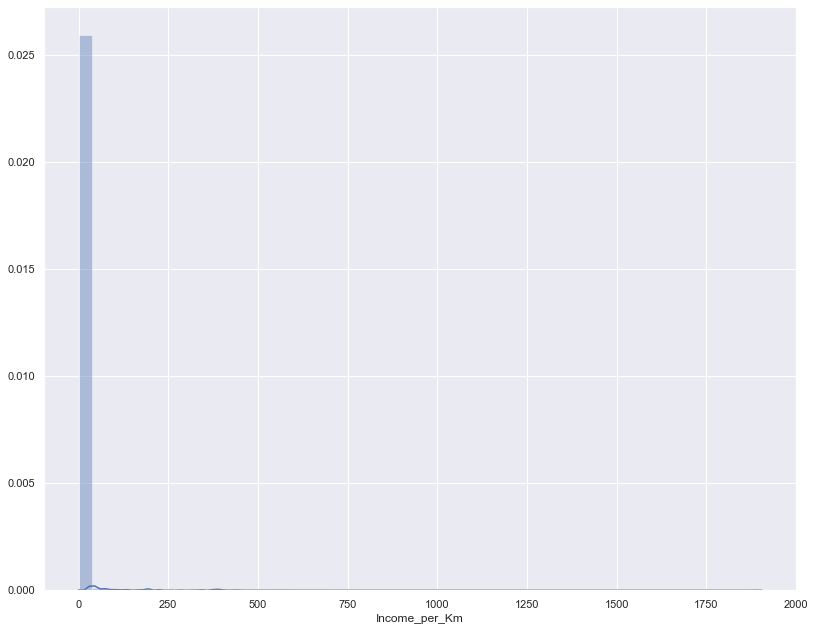

In [90]:
sns.set()
sns.distplot(df_sc['Income_per_Km'])

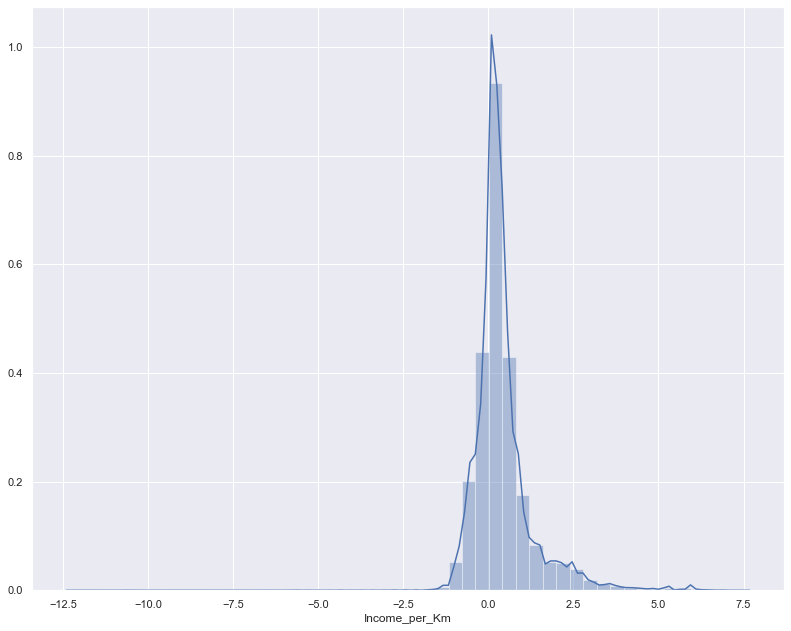

In [91]:
# Log 'Income_per_Km'
sns.set()
sns.distplot(np.log(df_sc.Income_per_Km))

#### Income_per_Day

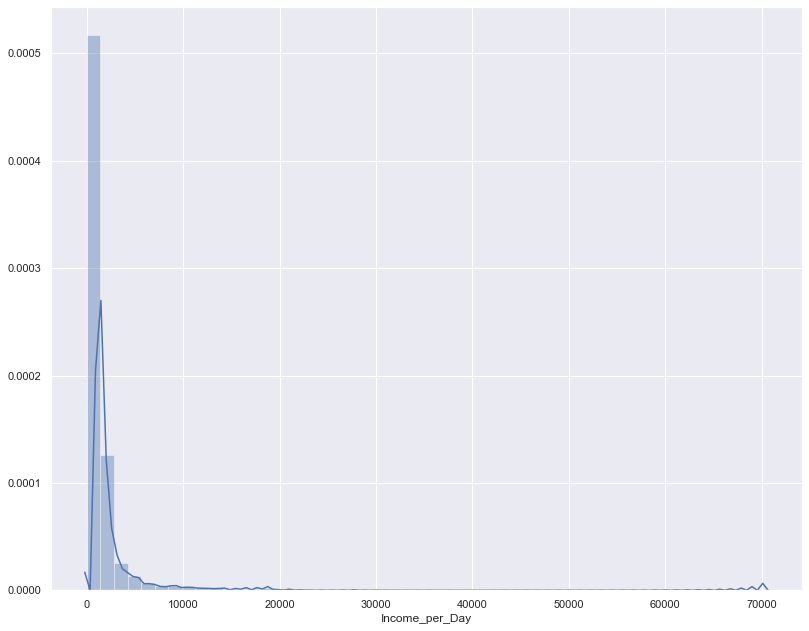

In [92]:
sns.set()
sns.distplot(df_sc['Income_per_Day'])

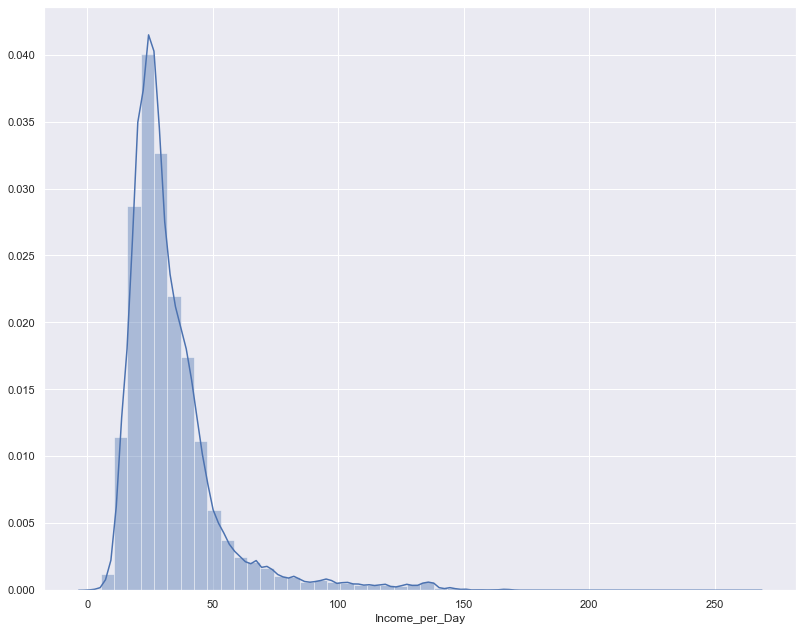

In [93]:
# Sqrt 'Income_per_Day' 
sns.set()
sns.distplot(np.sqrt(df_sc.Income_per_Day))

## Преобразование данных

Преобразование данных в соответствии с проведенным выше анализом.

In [94]:
# Transform 'Income' with Sqrt 
df_sc['Income'] = np.sqrt(df_sc.Income)
df_sc.Income.head()

0    49.497475
1    45.349090
2    33.166248
3    34.641016
4    33.911650
Name: Income, dtype: float64

In [95]:
# Transform 'Days' with Sqrt 
df_sc['Days'] = np.sqrt(df_sc.Days)
df_sc.Days.head()

0    2.404856
1    2.404717
2    2.404567
3    2.404279
4    2.404134
Name: Days, dtype: float64

In [96]:
# Transform 'Mileage' with Sqrt 
df_sc['Mileage'] = np.sqrt(df_sc.Mileage)
df_sc.Mileage.head()

0    46.054316
1    43.874822
2    45.825757
3    35.256205
4    47.063787
Name: Mileage, dtype: float64

In [97]:
# Transform 'Income_per_Km' with Log 
df_sc['Income_per_Km'] = np.log(df_sc.Income_per_Km)
df_sc.Income_per_Km.head()

0    0.144200
1    0.066099
2   -0.646627
3   -0.035206
4   -0.655490
Name: Income_per_Km, dtype: float64

In [98]:
# Transform 'Income_per_Day' with Sqrt 
df_sc['Income_per_Day'] = np.sqrt(df_sc.Income_per_Day)
df_sc.Income_per_Day.head() 

0    20.582301
1    18.858393
2    13.793021
3    14.408071
4    14.105556
Name: Income_per_Day, dtype: float64

In [99]:
df_sc.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,Ref,Canvas,Income_per_Km,Income_per_Day
0,145269,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,2.404856,46.054316,49.497475,1,0,0.144200,20.582301
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,2.404717,43.874822,45.349090,0,1,0.066099,18.858393
2,146618,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,2.404567,45.825757,33.166248,1,0,-0.646627,13.793021
3,164866,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,2.404279,35.256205,34.641016,1,0,-0.035206,14.408071
4,95810,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,2.404134,47.063787,33.911650,1,0,-0.655490,14.105556


In [100]:
df_n = df_sc.copy()

### Нормирование данных

In [101]:
column_names_to_normalize = ['Days', 'Mileage', 'Income_per_Km', 'Income_per_Day', 'Income'] #'Income'
df_norm = df_n[column_names_to_normalize].values
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_norm)
df_temp = pd.DataFrame(df_scaled, columns=column_names_to_normalize, index = df_n.index)
df_norm = df_n
df_norm[column_names_to_normalize] = df_temp
df_norm.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,Ref,Canvas,Income_per_Km,Income_per_Day
0,145269,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,1.000000,0.891009,0.830226,1,0,0.626308,0.077390
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,0.999938,0.847907,0.760504,0,1,0.622368,0.070895
2,146618,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,0.999872,0.886489,0.555746,1,0,0.586415,0.051808
3,164866,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,0.999745,0.677462,0.580533,1,0,0.617258,0.054125
4,95810,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,0.999681,0.910973,0.568274,1,0,0.585968,0.052985


In [102]:
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,Ref,Canvas,Income_per_Km,Income_per_Day
0,145269,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,5.783333,2121.0,2450.00,1,0,1.155116,423.631124
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,5.782662,1925.0,2056.54,0,1,1.068332,355.638975
2,146618,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,5.781944,2100.0,1100.00,1,0,0.523810,190.247418
3,164866,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,5.780556,1243.0,1200.00,1,0,0.965406,207.592504
4,95810,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,5.779861,2215.0,1150.00,1,0,0.519187,198.966719


In [103]:
df_sc.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,Ref,Canvas,Income_per_Km,Income_per_Day
0,145269,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,2.404856,46.054316,49.497475,1,0,0.144200,20.582301
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,2.404717,43.874822,45.349090,0,1,0.066099,18.858393
2,146618,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,2.404567,45.825757,33.166248,1,0,-0.646627,13.793021
3,164866,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,2.404279,35.256205,34.641016,1,0,-0.035206,14.408071
4,95810,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,2.404134,47.063787,33.911650,1,0,-0.655490,14.105556


### Датафреймы:

- __*df*__ - исходные данные
- __*df_sc*__ - преобразованные данные при помощи sqrt или log
- __*df_norm*__ - преобразованные данные при помощи sqrt или log + нормированные

### Корреляция данных

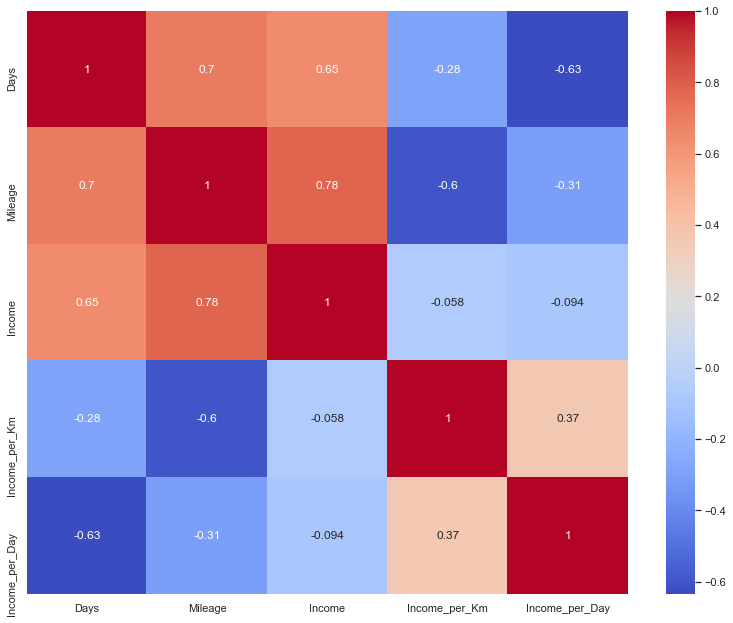

In [104]:
# Check variables correlation NORMALIZED DATA
#correlation = df.iloc[:,df.columns!='id'].corr()
correlation = df_norm[['Days', 'Mileage', 'Income', 'Income_per_Km', 'Income_per_Day']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [105]:
# Find all correlations with 'Income' and sort NORMALIZED DATA
correlations_df_NORM = df_norm.iloc[:,df_norm.columns!='id'].corr()['Income'].sort_values()
correlations_df_NORM

Canvas           -0.442820
TrailerType      -0.442820
Income_per_Day   -0.093566
Income_per_Km    -0.058215
Ref               0.442820
Days              0.645757
Mileage           0.777924
Income            1.000000
Name: Income, dtype: float64

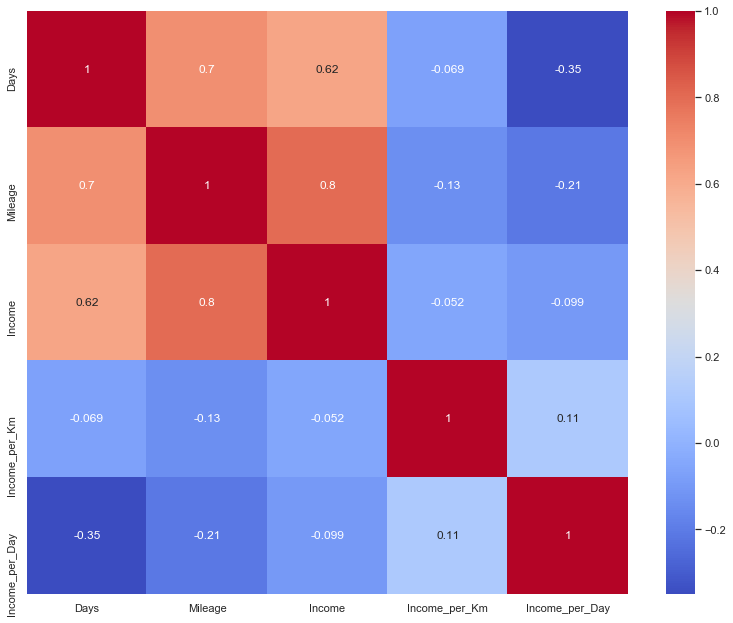

In [106]:
# Check variables correlation RAW DATA
#correlation = df.iloc[:,df.columns!='id'].corr()
correlation = df[['Days', 'Mileage', 'Income', 'Income_per_Km', 'Income_per_Day']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [107]:
# Find all correlations with 'Income' and sort RAW DATA
correlations_df_RAW = df.iloc[:,df.columns!='id'].corr()['Income'].sort_values()
correlations_df_RAW

TrailerType      -0.430335
Canvas           -0.430335
Income_per_Day   -0.098800
Income_per_Km    -0.051918
Ref               0.430335
Days              0.623106
Mileage           0.803989
Income            1.000000
Name: Income, dtype: float64

## Principal Component Analysis (PCA)

Для построения рейтинга при помощи PCA исользуются след. переменные:
    - Дни
    - Пробег
    - Доход на км
    - Доход на день
    - Доход

Сначала рассчитываются главные компоненты. Затем значения усредняются по маршруту (регионам, почтовым кодам), ранжируются.

In [108]:
pca = PCA(n_components=2)

In [109]:
columns_for_pca = df_norm[['Days','Mileage','Income_per_Km', 'Income_per_Day', 'Income']]

In [110]:
pca.fit(columns_for_pca)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [111]:
print(pca.components_)

[[ 0.65155882  0.60955853 -0.06042496 -0.11692571  0.43195684]
 [-0.66490873  0.4700761  -0.02901777  0.37949322  0.43825529]]


In [112]:
## The percentage of the explained variance 
pca.explained_variance_ratio_

array([0.77110404, 0.13865343])

In [113]:
X_pca = pca.transform(columns_for_pca)
print("original shape:   ", columns_for_pca.shape)
print("transformed shape:", X_pca.shape)

original shape:    (172775, 5)
transformed shape: (172775, 2)


In [114]:
principalComponents = pca.fit_transform(columns_for_pca)

In [115]:
principalComponents

array([[ 0.87575607, -0.05371498],
       [ 0.82032311, -0.10684229],
       [ 0.75975611, -0.18459804],
       ...,
       [-0.27748729,  0.37521542],
       [-0.515212  ,  0.18129661],
       [-0.37278261,  0.28449022]])

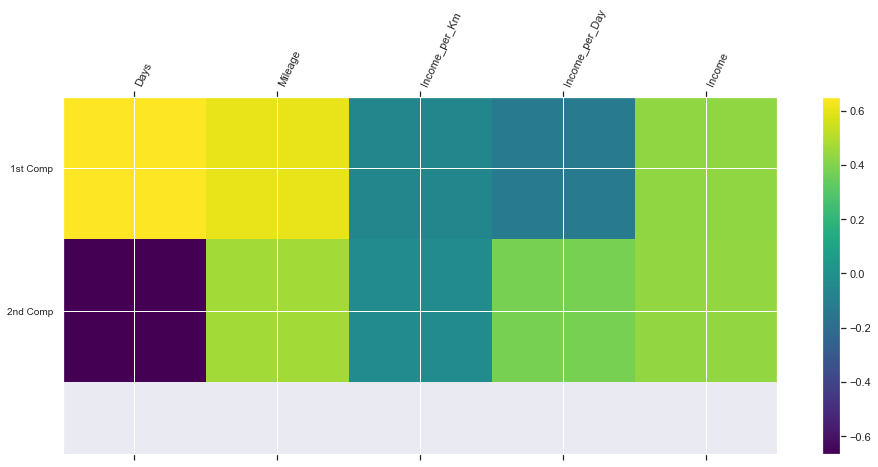

In [116]:
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2],['1st Comp','2nd Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(columns_for_pca.columns)),columns_for_pca.columns,rotation=65,ha='left')
plt.show()

In [117]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
principalDf

,pc1,pc2
0,0.875756,-0.053715
1,0.820323,-0.106842
2,0.759756,-0.184598
3,0.640831,-0.271924
4,0.779856,-0.167011
...,...,...
172770,-0.315779,0.333118
172771,-0.493169,0.192880
172772,-0.277487,0.375215
172773,-0.515212,0.181297


### Таблица результатов PCA

In [118]:
pcs = df_norm[['id','Route','Regions','PostCodes']].join(principalDf)
pcs.tail()

,id,Route,Regions,PostCodes,pc1,pc2
172770,171298,DE-IT,CentralEurope-Italy,DE75 - IT24,-0.315779,0.333118
172771,177235,DE-DE,CentralEurope-CentralEurope,DE81 - DE86,-0.493169,0.192880
172772,178638,DE-FR,Denmark-North France,DE21 - FR59,-0.277487,0.375215
172773,179582,DE-DE,BENELUX-BENELUX,DE47 - DE44,-0.515212,0.181297
172774,179710,DE-DE,BENELUX-BENELUX,DE44 - DE41,-0.372783,0.284490


#### Нормирование главных компонент

In [119]:
pcs['pc1_norm'] = scaler.fit_transform(pcs[['pc1']].values)
pcs['pc2_norm'] = scaler.fit_transform(pcs[['pc2']].values)
pcs.head()

,id,Route,Regions,PostCodes,pc1,pc2,pc1_norm,pc2_norm
0,145269,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,0.875756,-0.053715,0.923685,0.409396
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,0.820323,-0.106842,0.890408,0.373139
2,146618,LV-BE,Baltics-BENELUX,LVLV - BE08,0.759756,-0.184598,0.854049,0.320074
3,164866,AT-DE,CentralEurope-BENELUX,AT50 - DE29,0.640831,-0.271924,0.782657,0.260478
4,95810,LV-IT,Baltics-Italy,LVLV - IT48,0.779856,-0.167011,0.866115,0.332077


In [120]:
pcs.tail()

,id,Route,Regions,PostCodes,pc1,pc2,pc1_norm,pc2_norm
172770,171298,DE-IT,CentralEurope-Italy,DE75 - IT24,-0.315779,0.333118,0.208395,0.673391
172771,177235,DE-DE,CentralEurope-CentralEurope,DE81 - DE86,-0.493169,0.192880,0.101906,0.577685
172772,178638,DE-FR,Denmark-North France,DE21 - FR59,-0.277487,0.375215,0.231382,0.702120
172773,179582,DE-DE,BENELUX-BENELUX,DE47 - DE44,-0.515212,0.181297,0.088673,0.569780
172774,179710,DE-DE,BENELUX-BENELUX,DE44 - DE41,-0.372783,0.284490,0.174175,0.640205


## Routes Results
Таблица результатов по маршрутам

In [121]:
pcs.groupby(pcs.Route, as_index=False)['pc1_norm'].mean()

,pc1_norm
0,0.429775
1,0.527910
2,0.748680
3,0.533065
4,0.303631
...,...
504,0.332436
505,0.688989
506,0.903181
507,0.561813


In [122]:
res_routes = pcs.groupby(pcs.Route, as_index=False)['pc1_norm'].mean()
res_routes.head()

,Route,pc1_norm
0,AT-AT,0.429775
1,AT-BE,0.527910
2,AT-BG,0.748680
3,AT-CH,0.533065
4,AT-CZ,0.303631


Отсортированная таблица рейтинга маршрутов по методике PCA

In [123]:
res_routes = res_routes.sort_values(by='pc1_norm', ascending=False)
res_routes.index=pd.RangeIndex(start=1,stop=len(res_routes)+1,step=1)
res_routes.head(15)

,Route,pc1_norm
1,ES-EE,0.985969
2,BG-FR,0.959574
3,ES-GR,0.952937
4,NO-CH,0.949703
5,LU-BG,0.938628
6,SE-BG,0.937481
7,FR-GR,0.937301
8,DK-BG,0.932286
9,BE-GR,0.931701
10,GR-LT,0.928416


In [124]:
res_routes.tail(15)

,Route,pc1_norm
495,PL-PL,0.242570
496,HU-SK,0.239992
497,CH-CH,0.238689
498,DE-DE,0.238653
499,NL-BE,0.232929
500,BE-BE,0.228880
501,NL-NL,0.228561
502,IT-IT,0.226837
503,LV-LV,0.220800
504,FI-EE,0.216808


In [125]:
res_routes.to_csv(r'rating_PCA_routes.csv', index = False)
rating_PCA_routes.index=pd.RangeIndex(start=1,stop=len(res_routes)+1,step=1)
#render dataframe as html
html = rating_PCA_routes.to_html()
text_file = open("rating_PCA_routes.html", "w")
text_file.write(html)
text_file.close()

По результатам видно, что как правило невыгодными являются маршруты внутри стран (HU-HU, DK-DK, CZ-CZ, ES-ES). Самым выгодным оказался маршурт достаточно продолжительный маршрут ES-EE.

## Regions Results

Таблица результатов по регионам

In [126]:
pcs.groupby(pcs.Regions, as_index=False)['pc1_norm'].mean()

,Regions,pc1_norm
0,-Baltics,0.326259
1,BENELUX-,0.805659
2,BENELUX-BENELUX,0.238956
3,BENELUX-Balkans / Turkey,0.850882
4,BENELUX-Baltics,0.777809
...,...,...
175,UK-Poland,0.876790
176,UK-South France,0.381047
177,UK-Spain,0.724848
178,UK-UK,0.245177


In [127]:
res_regions = pcs.groupby(pcs.Regions, as_index=False)['pc1_norm'].mean()
res_regions.head()

,Regions,pc1_norm
0,-Baltics,0.326259
1,BENELUX-,0.805659
2,BENELUX-BENELUX,0.238956
3,BENELUX-Balkans / Turkey,0.850882
4,BENELUX-Baltics,0.777809


Отсортированная таблица рейтинга регионов по методике PCA

In [128]:
res_regions = res_regions.sort_values(by='pc1_norm', ascending=False)
res_regions.index=pd.RangeIndex(start=1,stop=len(res_regions)+1,step=1)
res_regions.head(15)

,Regions,pc1_norm
1,Spain-Baltics,0.985969
2,Balkans / Turkey-North France,0.959574
3,Spain-Greece,0.952937
4,North France-Greece,0.950280
5,Denmark-Greece,0.942815
6,South France-Greece,0.928224
7,Greece-Baltics,0.928024
8,BENELUX-Greece,0.913679
9,Greece-North France,0.896746
10,South France-Norway (South),0.888697


In [129]:
res_regions.tail(15)

,Regions,pc1_norm
166,Poland-CentralEurope,0.340147
167,Denmark-CentralEurope,0.335116
168,Sweden-Sweden,0.326622
169,-Baltics,0.326259
170,South France-South France,0.296005
171,Baltics-Baltics,0.288249
172,Denmark-Denmark,0.280510
173,North France-North France,0.271774
174,CentralEurope-CentralEurope,0.266731
175,UK-UK,0.245177


In [130]:
res_regions.to_csv(r'rating_PCA_regions.csv', index = False)
rating_PCA_regions.index=pd.RangeIndex(start=1,stop=len(res_regions)+1,step=1)
#render dataframe as html
html = rating_PCA_regions.to_html()
text_file = open("rating_PCA_regions.html", "w")
text_file.write(html)
text_file.close()

По результатам рейтинга по регионам внезапно оказалось, что маршруты по Греции достаточно выгодные. Также как и с маршрутами, поездки внутри региона не являются выгодными (Spain-Spain, Italy-Italy, BENELUX-BENELUX, Poland-Poland).

## PostCodes Results

Таблица результатов по почтовым кодам

In [131]:
pcs.groupby(pcs.PostCodes, as_index=False)['pc1_norm'].mean()

,PostCodes,pc1_norm
0,AT - AT,0.465658
1,AT - BE,0.460273
2,AT - CH,0.544211
3,AT - DE,0.419368
4,AT - DK,0.521851
...,...,...
18146,SK93 - SE25,0.632557
18147,SK96 - SE12,0.858283
18148,TR13 - DE30,0.561813
18149,TR13 - IT24,0.377781


In [132]:
res_postcodes = pcs.groupby(pcs.PostCodes, as_index=False)['pc1_norm'].mean()
res_postcodes.head()

,PostCodes,pc1_norm
0,AT - AT,0.465658
1,AT - BE,0.460273
2,AT - CH,0.544211
3,AT - DE,0.419368
4,AT - DK,0.521851


Отсортированная таблица рейтинга почтовых кодов по методике PCA

In [133]:
res_postcodes = res_postcodes.sort_values(by='pc1_norm', ascending=False)
res_postcodes.index=pd.RangeIndex(start=1,stop=len(res_postcodes)+1,step=1)
res_postcodes.head(15)

,PostCodes,pc1_norm
1,FR - GR,1.000000
2,IT80 - SE64,0.990548
3,ES30 - EE48,0.985969
4,DE29 - GR19,0.982161
5,DE31 - GRGR,0.978504
6,FR62 - GR35,0.975001
7,NO60 - FR50,0.972435
8,IT12 - NO17,0.971260
9,ES46 - DK26,0.970285
10,NO91 - PL17,0.963319


In [134]:
res_postcodes.tail(15)

,PostCodes,pc1_norm
18137,SE21 - SE23,0.070857
18138,NO57 - NO04,0.070817
18139,NO43 - NO43,0.069530
18140,NO20 - NO09,0.068940
18141,NL76 - NL71,0.067011
18142,GBTW - GBNW,0.065824
18143,ES04 - ES04,0.056420
18144,GBTW - GBSL,0.050886
18145,NL74 - BE39,0.049691
18146,DK41 - DK04,0.046705


In [135]:
res_postcodes.to_csv(r'rating_PCA_postcodes.csv', index = False)
rating_PCA_postcodes.index=pd.RangeIndex(start=1,stop=len(res_postcodes)+1,step=1)
#render dataframe as html
html = rating_PCA_postcodes.to_html()
text_file = open("rating_PCA_postcodes.html", "w")
text_file.write(html)
text_file.close()

Аналогично, как в рейтинге по регионам, рейтинг по почтовым кодам показал, что нужно выбирать маршруты в Грецию, которые оказались в топе (FR-GR, DE-GR). Как уже показали два предыдущих рейтинга - не стоит выбирать маршруты внутри страны (региона).

## Data Envelopment Analysis (DEA)

DEA позволяет оценить эффективность маршрутов на основе входных и выходных переменных.

#### Input:
1. Mileage
2. Days

#### Output:
1. Income

Построено 3 рейтинга: по маршрутам, регионам и почтовым кодам.

Поскольку в Python не реализован метод DEA, импортируем пакеты из R

In [137]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [138]:
r_utils = importr('utils')
r_Benchmarking = importr('Benchmarking')
r_ggplot2 = importr('ggplot2')

In [ ]:
#help(r_Benchmarking)

### DEA Routes
Для данного рейтинга рассчитаем количество поездок по каждому маршруту и уберем поездки, которые были 1 раз за период.

In [139]:
# Input
dea_input_routes =  df_norm.groupby(df_norm.Route, as_index=False).mean().loc[:,['Route','Days','Mileage']]
dea_input_routes.head()

,Route,Days,Mileage
0,AT-AT,0.475339,0.398229
1,AT-BE,0.469483,0.590089
2,AT-BG,0.791443,0.748452
3,AT-CH,0.539449,0.520889
4,AT-CZ,0.298183,0.306090


In [140]:
# Output
dea_output_routes = df_norm.groupby(df_norm.Route, as_index=False)['Income'].mean()
dea_output_routes.head()

,Route,Income
0,AT-AT,0.414944
1,AT-BE,0.535158
2,AT-BG,0.670601
3,AT-CH,0.548626
4,AT-CZ,0.336714


Подсчет количества перевозок по маршруту, чтобы убрать единичные поездки из рейтинга.

In [141]:
# Count of Routes 
df_routecounts = df_norm.Route.value_counts().rename_axis('Route').reset_index(name='RouteCounts')
df_routecounts.tail()

,Route,RouteCounts
504,SE-RS,1
505,ES-PT,1
506,EE-LU,1
507,LI-NL,1
508,BG-HU,1


In [142]:
# Merge two data frames
dea_input_routes = dea_input_routes.merge(df_routecounts, on='Route')
dea_input_routes.head()

,Route,Days,Mileage,RouteCounts
0,AT-AT,0.475339,0.398229,17
1,AT-BE,0.469483,0.590089,12
2,AT-BG,0.791443,0.748452,1
3,AT-CH,0.539449,0.520889,13
4,AT-CZ,0.298183,0.306090,35


In [143]:
dea_output_routes = dea_output_routes.merge(df_routecounts, on='Route')
dea_output_routes.head()

,Route,Income,RouteCounts
0,AT-AT,0.414944,17
1,AT-BE,0.535158,12
2,AT-BG,0.670601,1
3,AT-CH,0.548626,13
4,AT-CZ,0.336714,35


In [144]:
# Remove routes with counts==1
dea_input_routes = dea_input_routes[dea_input_routes.RouteCounts>1]
dea_input_routes.index=pd.RangeIndex(start=0,stop=len(dea_input_routes),step=1)

dea_input_routes.to_csv(r'dea_input_routes.csv', index = False)
dea_input_routes.head()

,Route,Days,Mileage,RouteCounts
0,AT-AT,0.475339,0.398229,17
1,AT-BE,0.469483,0.590089,12
2,AT-CH,0.539449,0.520889,13
3,AT-CZ,0.298183,0.306090,35
4,AT-DE,0.275248,0.506062,311


In [145]:
# Remove routes with counts==1
dea_output_routes = dea_output_routes[dea_output_routes.RouteCounts>1]
dea_output_routes.index=pd.RangeIndex(start=0,stop=len(dea_output_routes),step=1)

# Remove RouteCouns column
#dea_output_routes = dea_output_routes.iloc[:,dea_output_routes.columns!='RouteCounts']

dea_output_routes.to_csv(r'dea_output_routes.csv', index = False)
dea_output_routes.head()

,Route,Income,RouteCounts
0,AT-AT,0.414944,17
1,AT-BE,0.535158,12
2,AT-CH,0.548626,13
3,AT-CZ,0.336714,35
4,AT-DE,0.467322,311


Построение модели без учета масштаба, ориентированную на выход. Вывод результатов в df c сортировкой по эффективности по возрастанию.

In [146]:
dea_model_routes = np.array(r_Benchmarking.dea(dea_input_routes[['Days','Mileage']], dea_output_routes[['Income']], SLACK=True , 
                            RTS="VRS", ORIENTATION="OUT"))
# dea_model_routes[0][:10]
dea_model_routes = pd.DataFrame({"eff":dea_model_routes[0]})
dea_model_routes.head()

,eff
0,1.542358
1,1.429634
2,1.429753
3,1.504276
4,1.218112


In [147]:
dea_res_routes = pd.concat([dea_input_routes[['Route']], dea_model_routes[['eff']]], axis=1)

In [148]:
dea_res_routes = dea_res_routes.sort_values("eff", ascending=True)
dea_res_routes.head()

,Route,eff
143,ES-ES,1.0
216,HU-HU,1.0
207,HR-IT,1.0
63,CZ-CZ,1.0
235,IT-FI,1.0


Добавляем количество поездок в итоговый рейтинг. 

Лидеры:

In [150]:
dea_res_routes.merge(df_routecounts, on='Route')
dea_res_routes.index=pd.RangeIndex(start=1,stop=len(dea_res_routes)+1,step=1)

dea_res_routes.to_csv(r'rating_DEA_routes.csv', index = False)
rating_DEA_routes.index=pd.RangeIndex(start=1,stop=len(dea_res_routes)+1,step=1)
#render dataframe as html
html = rating_DEA_routes.to_html()
text_file = open("rating_DEA_routes.html", "w")
text_file.write(html)
text_file.close()
dea_res_routes.head(15)

,Route,eff
1,ES-ES,1.000000
2,HU-HU,1.000000
3,HR-IT,1.000000
4,CZ-CZ,1.000000
5,IT-FI,1.000000
6,NL-IE,1.000000
7,NO-GB,1.000000
8,GR-LT,1.000000
9,NL-SE,1.001269
10,NL-AX,1.014957


Аутсайдеры:

In [151]:
dea_res_routes.tail(15)

,Route,eff
399,SE-FI,1.852711
400,SE-EE,1.869277
401,SK-FR,1.891270
402,LV-PL,1.892060
403,SK-DE,1.950080
404,SE-LT,1.952057
405,FI-SE,1.954971
406,FI-DE,1.963522
407,LT-PL,1.965573
408,NL-PL,1.973003


### DEA Routes frontier
<!--<img src="Rplot03.png" width=800/>-->
<!--![plot of chunk unnamed-chunk-2](./Seminar_02_assignment_markdown_Tal_files/figure-html/unnamed-chunk-2.png)-->
![dea_routes.png](dea_routes.png)

В рейтинге DEA маршруты со значением 1 являются эффективными, чем меньше значение в колонке __eff__, тем лучше.
По рейтингу эффективности маршрутов лучшими оказались наоброт маршруты внутри страны, поскольку, как правило, такие маршруты короче по продолжительности и расстоянию, и в некоторых случаях выше по стоимости.
Неэффективными оказались маршруты LT-LV, LV-LT, очевидно минимальные по входным данным, но также невысокие и по выходным, что и сделало их неэффективными. Также, стоит отметить, что в рейтинг, в отличие от PCA, не включены маршруты с одной поездкой за весь период. Т.к. вряд ли мы выберем этот маршрут даже если он самый эффективный.

### DEA Regions

Для данного рейтинга рассчитаем количество поездок по каждому региону, предварительно убрав из расчета регионы с непольностью заполненными значениями. А также уберем поездки, которые были 1 раз за период.

In [152]:
# Copying df for Regions, as need to remove unnecessary rows
df_norm_regions = df_norm.copy()

In [153]:
# Find rows with not fully filled regions (only one of regions) or equal to 'no data-no data'
remove_index_routes = []
df_norm_regions['Regions'][1].split('-')
for i in range(len(df_norm_regions.Regions)):
    if(df_norm_regions['Regions'][i].split('-')[0]=='' or df_norm_regions['Regions'][i].split('-')[1]==''
      or df_norm_regions['Regions'][i]=='no data-no data'
      ):
        remove_index_routes.append(i)
        df_norm_regions=df_norm_regions.drop(i)
#print(remove_index_routes) 

In [154]:
# Input
dea_input_regions =  df_norm_regions.groupby(df_norm_regions.Regions, as_index=False).mean().loc[:,['Regions','Days','Mileage']]
dea_input_regions.head()

,Regions,Days,Mileage
0,BENELUX-BENELUX,0.211138,0.242634
1,BENELUX-Balkans / Turkey,0.824364,0.897529
2,BENELUX-Baltics,0.703090,0.889986
3,BENELUX-CentralEurope,0.329691,0.395684
4,BENELUX-Denmark,0.315274,0.425431


In [155]:
# Output
dea_output_regions = df_norm_regions.groupby(df_norm_regions.Regions, as_index=False)['Income'].mean()
dea_output_regions.head()

,Regions,Income
0,BENELUX-BENELUX,0.320257
1,BENELUX-Balkans / Turkey,0.808473
2,BENELUX-Baltics,0.719845
3,BENELUX-CentralEurope,0.379153
4,BENELUX-Denmark,0.462759


Подсчет количества перевозок по регионам, чтобы убрать единичные поездки из рейтинга.

In [156]:
# Count of Regions 
df_regionscounts = df_norm_regions.Regions.value_counts().rename_axis('Regions').reset_index(name='RegionsCounts')
df_regionscounts.tail()

,Regions,RegionsCounts
170,Spain-Baltics,1
171,UK-Poland,1
172,Poland-Norway (South),1
173,Balkans / Turkey-North France,1
174,Spain-Norway (South),1


In [157]:
# Merge two data frames
dea_input_regions = dea_input_regions.merge(df_regionscounts, on='Regions')
dea_input_regions.head()

,Regions,Days,Mileage,RegionsCounts
0,BENELUX-BENELUX,0.211138,0.242634,28326
1,BENELUX-Balkans / Turkey,0.824364,0.897529,73
2,BENELUX-Baltics,0.703090,0.889986,1359
3,BENELUX-CentralEurope,0.329691,0.395684,4126
4,BENELUX-Denmark,0.315274,0.425431,5998


In [158]:
dea_output_regions = dea_output_regions.merge(df_regionscounts, on='Regions')
dea_output_regions.head()

,Regions,Income,RegionsCounts
0,BENELUX-BENELUX,0.320257,28326
1,BENELUX-Balkans / Turkey,0.808473,73
2,BENELUX-Baltics,0.719845,1359
3,BENELUX-CentralEurope,0.379153,4126
4,BENELUX-Denmark,0.462759,5998


In [159]:
# Remove regions with counts==1
dea_input_regions = dea_input_regions[dea_input_regions.RegionsCounts>1]
dea_input_regions.index=pd.RangeIndex(start=0,stop=len(dea_input_regions),step=1)

dea_input_regions.to_csv(r'dea_input_regions.csv', index = False)
dea_input_regions.head()

,Regions,Days,Mileage,RegionsCounts
0,BENELUX-BENELUX,0.211138,0.242634,28326
1,BENELUX-Balkans / Turkey,0.824364,0.897529,73
2,BENELUX-Baltics,0.703090,0.889986,1359
3,BENELUX-CentralEurope,0.329691,0.395684,4126
4,BENELUX-Denmark,0.315274,0.425431,5998


In [160]:
# Remove regions with counts==1
dea_output_regions = dea_output_regions[dea_output_regions.RegionsCounts>1]
dea_output_regions.index=pd.RangeIndex(start=0,stop=len(dea_output_regions),step=1)

# Remove RegionsCounts column
#dea_output_regions = dea_output_regions.iloc[:,dea_output_regions.columns!='RegionsCounts']

dea_output_regions.to_csv(r'dea_output_regions.csv', index = False)
dea_output_regions.head()

,Regions,Income,RegionsCounts
0,BENELUX-BENELUX,0.320257,28326
1,BENELUX-Balkans / Turkey,0.808473,73
2,BENELUX-Baltics,0.719845,1359
3,BENELUX-CentralEurope,0.379153,4126
4,BENELUX-Denmark,0.462759,5998


Построение модели без учета масштаба, ориентированную на выход. Вывод результатов в df c сортировкой по эффективности по возрастанию.

In [161]:
dea_model_regions = np.array(r_Benchmarking.dea(dea_input_regions[['Days','Mileage']], dea_output_regions[['Income']], SLACK=True , 
                            RTS="VRS", ORIENTATION="OUT"))
# dea_model_regions[0][:10]
dea_model_regions = pd.DataFrame({"eff":dea_model_regions[0]})
dea_model_regions.head()

,eff
0,1.244335
1,1.158512
2,1.293389
3,1.392526
4,1.174772


In [162]:
dea_res_regions = pd.concat([dea_input_regions[['Regions']], dea_model_regions[['eff']]], axis=1)

In [163]:
dea_res_regions = dea_res_regions.sort_values("eff", ascending=True)
dea_res_regions.head()

,Regions,eff
109,Norway (South)-UK,1.0
66,Greece-Denmark,1.0
143,Spain-Spain,1.0
133,South France-Sweden,1.0
129,South France-Norway (South),1.0


Добавляем количество поездок в итоговый рейтинг.

Лидеры:

In [164]:
dea_res_regions.merge(df_regionscounts, on='Regions')
dea_res_regions.index=pd.RangeIndex(start=1,stop=len(dea_res_regions)+1,step=1)

dea_res_regions.to_csv(r'rating_DEA_regions.csv', index = False)
rating_DEA_regions.index=pd.RangeIndex(start=1,stop=len(dea_res_regions)+1,step=1)
#render dataframe as html
html = rating_DEA_regions.to_html()
text_file = open("rating_DEA_regions.html", "w")
text_file.write(html)
text_file.close()
dea_res_regions.head(15)

,Regions,eff
1,Norway (South)-UK,1.000000
2,Greece-Denmark,1.000000
3,Spain-Spain,1.000000
4,South France-Sweden,1.000000
5,South France-Norway (South),1.000000
6,BENELUX-Sweden,1.000198
7,Greece-Baltics,1.002513
8,Italy-Norway (South),1.003232
9,BENELUX-Norway (South),1.005156
10,Denmark-UK,1.006176


Аутсайдеры:

In [165]:
dea_res_regions.tail(15)

,Regions,eff
154,North France-Spain,1.499563
155,Denmark-BENELUX,1.503301
156,Baltics-CentralEurope,1.509971
157,North France-Poland,1.514862
158,Poland-BENELUX,1.521147
159,South France-Italy,1.524323
160,Baltics-South France,1.545087
161,UK-BENELUX,1.549467
162,South France-Spain,1.551764
163,Denmark-Poland,1.566553


### DEA PostCodes

Для данного рейтинга рассчитаем количество поездок по почтовым кодам, убрав поездки, которые были 1 раз за период.

In [166]:
# Input
dea_input_postcodes =  df_norm.groupby(df_norm.PostCodes, as_index=False).mean().loc[:,['PostCodes','Days','Mileage']]
dea_input_postcodes.head()

,PostCodes,Days,Mileage
0,AT - AT,0.463059,0.462462
1,AT - BE,0.349727,0.547550
2,AT - CH,0.492753,0.561763
3,AT - DE,0.336937,0.496891
4,AT - DK,0.432173,0.592652


In [167]:
# Output
dea_output_postcodes = df_norm.groupby(df_norm.PostCodes, as_index=False)['Income'].mean()
dea_output_postcodes.head()

,PostCodes,Income
0,AT - AT,0.484197
1,AT - BE,0.522729
2,AT - CH,0.610078
3,AT - DE,0.455040
4,AT - DK,0.568274


Подсчет количества перевозок по почтовым кодам, чтобы убрать единичные поездки из рейтинга.

In [168]:
# Count of Routes 
df_postcodescounts = df_norm.PostCodes.value_counts().rename_axis('PostCodes').reset_index(name='PostCodesCounts')
df_postcodescounts.tail()

,PostCodes,PostCodesCounts
18146,ES13 - ES20,1
18147,SE19 - NO15,1
18148,NO06 - NL29,1
18149,NO60 - SE41,1
18150,SE57 - DK21,1


In [169]:
# Merge two data frames
dea_input_postcodes = dea_input_postcodes.merge(df_postcodescounts, on='PostCodes')
dea_input_postcodes.head()

,PostCodes,Days,Mileage,PostCodesCounts
0,AT - AT,0.463059,0.462462,2
1,AT - BE,0.349727,0.547550,2
2,AT - CH,0.492753,0.561763,2
3,AT - DE,0.336937,0.496891,30
4,AT - DK,0.432173,0.592652,1


In [170]:
dea_output_postcodes = dea_output_postcodes.merge(df_postcodescounts, on='PostCodes')
dea_output_postcodes.head()

,PostCodes,Income,PostCodesCounts
0,AT - AT,0.484197,2
1,AT - BE,0.522729,2
2,AT - CH,0.610078,2
3,AT - DE,0.455040,30
4,AT - DK,0.568274,1


In [171]:
# Remove postcodes with counts==1
dea_input_postcodes = dea_input_postcodes[dea_input_postcodes.PostCodesCounts>1]
dea_input_postcodes.index=pd.RangeIndex(start=0,stop=len(dea_input_postcodes),step=1)

dea_input_postcodes.to_csv(r'dea_input_postcodes.csv', index = False)
dea_input_postcodes.head()

,PostCodes,Days,Mileage,PostCodesCounts
0,AT - AT,0.463059,0.462462,2
1,AT - BE,0.349727,0.547550,2
2,AT - CH,0.492753,0.561763,2
3,AT - DE,0.336937,0.496891,30
4,AT - FR,0.611620,0.626353,7


In [172]:
# Remove postcodes with counts==1
dea_output_postcodes = dea_output_postcodes[dea_output_postcodes.PostCodesCounts>1]
dea_output_postcodes.index=pd.RangeIndex(start=0,stop=len(dea_output_postcodes),step=1)

# Remove RouteCouns column
#dea_output_postcodes = dea_output_postcodes.iloc[:,dea_output_postcodes.columns!='RouteCounts']

dea_output_postcodes.to_csv(r'dea_output_postcodes.csv', index = False)
dea_output_postcodes.head()

,PostCodes,Income,PostCodesCounts
0,AT - AT,0.484197,2
1,AT - BE,0.522729,2
2,AT - CH,0.610078,2
3,AT - DE,0.455040,30
4,AT - FR,0.587975,7


Построение модели без учета масштаба, ориентированную на выход. Вывод результатов в df c сортировкой по эффективности по возрастанию.

In [173]:
dea_model_postcodes = np.array(r_Benchmarking.dea(dea_input_postcodes[['Days','Mileage']], dea_output_postcodes[['Income']], SLACK=True , 
                            RTS="VRS", ORIENTATION="OUT"))
# dea_model_postcodes[0][:10]
dea_model_postcodes = pd.DataFrame({"eff":dea_model_postcodes[0]})
dea_model_postcodes.head()

,eff
0,1.698874
1,1.549267
2,1.415283
3,1.760897
4,1.535494


In [175]:
dea_res_postcodes = pd.concat([dea_input_postcodes[['PostCodes']], dea_model_postcodes[['eff']]], axis=1)

In [176]:
dea_res_postcodes = dea_res_postcodes.sort_values("eff", ascending=True)
dea_res_postcodes.head()

,PostCodes,eff
6705,NL47 - NL47,1.0
99,BE15 - BE50,1.0
3489,ES18 - BE35,1.0
5502,IT42 - IT37,1.0
7831,NO64 - GBTW,1.0


Добавляем количество поездок в итоговый рейтинг.

Лидеры:

In [177]:
dea_res_postcodes.merge(df_postcodescounts, on='PostCodes')
dea_res_postcodes.index=pd.RangeIndex(start=1,stop=len(dea_res_postcodes)+1,step=1)

dea_res_postcodes.to_csv(r'rating_DEA_postcodes.csv', index = False)
rating_DEA_postcodes.index=pd.RangeIndex(start=1,stop=len(dea_res_postcodes)+1,step=1)
#render dataframe as html
html = rating_DEA_postcodes.to_html()
text_file = open("rating_DEA_postcodes.html", "w")
text_file.write(html)
text_file.close()
dea_res_postcodes.head(15)

,PostCodes,eff
1,NL47 - NL47,1.0
2,BE15 - BE50,1.0
3,ES18 - BE35,1.0
4,IT42 - IT37,1.0
5,NO64 - GBTW,1.0
6,DE53 - DE53,1.0
7,GBTW - GBUB,1.0
8,DE46 - DE46,1.0
9,FR94 - DE47,1.0
10,BE88 - NL53,1.0


Аутсайдеры:

In [178]:
dea_res_postcodes.tail(15)

,PostCodes,eff
9114,NL75 - NL29,4.230249
9115,SE45 - SE30,4.250188
9116,NL75 - DE41,4.278263
9117,NL74 - NL54,4.309531
9118,DE71 - NL67,4.334093
9119,NL74 - BE28,4.486817
9120,DK70 - DK67,4.490485
9121,NL74 - NL26,4.528152
9122,NL75 - NL74,4.555773
9123,NL81 - NL27,4.612972


## Дополнительно

Разработка модели, при помощи которой можно рассчитать доход от поездки.
На основе пробега, дней, типа прицепа

In [136]:
# Split into 70% training and 30% testing set # ,'Ref','Canvas'
X_train, X_test, y_train, y_test = train_test_split(df_sc[['Days','Mileage','Ref','Canvas']], # 'TrailerType'
                                                    pd.Series(df_sc['Income']), 
                                        test_size = 0.3, 
                                        random_state = 42)

In [137]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

baseline_guess = np.median(y_train)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 23.10
Baseline Performance on the test set: MAE = 7.1965


### Выбор модели по наименьшей MAE

In [138]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

### Линейная регрессия

In [139]:
from sklearn.linear_model import LinearRegression
# Create the model
lr = LinearRegression()
# Fit and evaluate the model 
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 4.2819


### Случайный лес (Random Forest)

In [140]:
from sklearn.ensemble import RandomForestRegressor
# Create the model
random_forest = RandomForestRegressor(random_state=60)
# Fit and evaluate the model 
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 2.9567


### Градиентный бустинг

In [141]:
from sklearn.ensemble import GradientBoostingRegressor
# Create the model
gradient_boosted = GradientBoostingRegressor(random_state=60)
# Fit and evaluate the model 
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 3.1999


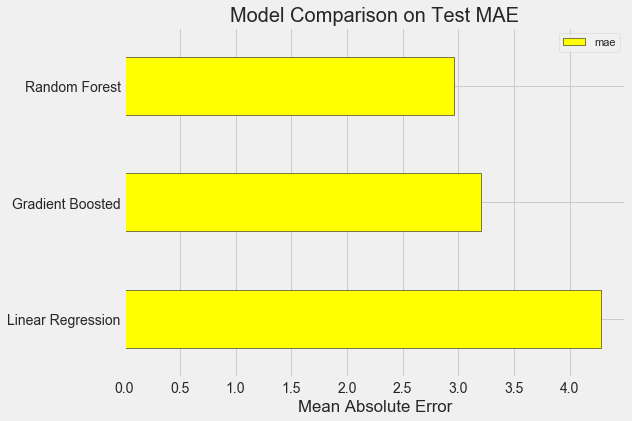

In [142]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 
                                           'Random Forest', 'Gradient Boosted'
                                          ],
                                 'mae': [lr_mae, random_forest_mae, 
                                         gradient_boosted_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'yellow', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

### Random Forest

In [143]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (120942, 4)
Training Labels Shape: (120942,)
Testing Features Shape: (51833, 4)
Testing Labels Shape: (51833,)


In [144]:
# Function to calculate mean absolute error
def mae(y_true, y_test):
    return np.mean(abs(y_true - y_test))

baseline_guess = np.median(y_train)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 23.10
Baseline Performance on the test set: MAE = 7.1965


In [145]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [146]:
#rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, 
#                               min_samples_split = 2, min_samples_leaf = 1)

## Make Predictions on Test Data

In [147]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error: 2.95 degrees.


In [148]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 86.03 %.
